In [1]:
import genomepy
from loguru import logger
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import minmax_scale
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import os 

os.getcwd()

'/bank/experiments/2022-04-jordi'

### variables

In [2]:
in_dir = "ananse_orthofinder/influence"
out_dir = "ananse_orthofinder/plot_labelled"


orthologs = "orthologs/orthologs_with_orthofinder.tsv"

n_tfs = 20
edge_info="weight"
edge_min=0.1

network_algorithm="neato"
cmap="viridis"
plot_type = "png"

In [3]:
tbl = pd.read_csv(orthologs, sep="\t", index_col=0)
tbl["orthologs"] = tbl["orthologs"].str.split("/")

curated_factor2human_factor = tbl["orthologs"].to_dict()
for k in list(curated_factor2human_factor)[0:5]:
    print(k, ":", curated_factor2human_factor[k])

tbl.sample(3)

SMEST000041001 : ['GFM2']
SMEST000042001 : ['AC093525.1', 'AMDHD2']
SMEST000046001 : ['GFM2']
SMEST000047001 : ['GFM2']
SMEST000092001 : ['CHD6', 'CHD8', 'CHD9', 'CHD7']


orthologs       source
gene_name                                  
SmMSTRG.2849            [LEO1]  orthofinder
SMEST041066001         [ABHD8]  orthofinder
SMEST069763001  [VASH1, VASH2]  orthofinder

In [4]:
# ogs = "/bank/experiments/2022-01-jordi/m2f_gimme.vertebrates/m2f_intermediate/prim_genes/OrthoFinder/Results_Feb16/Orthogroups/Orthogroups.tsv"
# df = pd.read_table(ogs)

# # remove unused data
# df = df[["Smed.pep", "GRCh38.p13.pep"]]
# df = df.dropna()
# df["Smed"] = df["Smed.pep"].str.replace("|.", "", regex=False).str.split(", ", expand=False, regex=False)
# df["GRCh38.p13"] = (
#     df["GRCh38.p13.pep"]
#     .str.replace("|.", "", regex=False)
#     .str.replace(".|", "", regex=False)
#     .str.replace("\|ENSG\d+", "", regex=True)
#     .str.split(", ", expand=False, regex=False)
# )

# df = df[["Smed", "GRCh38.p13"]]
# # df

# orhofinder2human_factor = {}
# # for t,g in t2g.items():
# for _, row in df.iterrows():
#     for transcript in row["Smed"]:
#         if transcript in t2g:
#             smed_gene = t2g[transcript]
#             human_orthologs = row["GRCh38.p13"]
#             orhofinder2human_factor[smed_gene] = human_orthologs

# orhofinder2human_factor

In [5]:
def read_diff_network(diff_network_file, full_output):
    """read the differential network file outputed by the influence command."""
    data_columns = ["source", "target", "weight"]
    if full_output:
        data_columns = None  # all
    rnet = pd.read_csv(
        diff_network_file,
        sep="\t",
        usecols=data_columns,
        dtype="float64",
        converters={"source": str, "target": str},
#         engine="python",
    )
    grn = nx.from_pandas_edgelist(rnet, edge_attr=True, create_using=nx.DiGraph)
    return grn


def sorted_tfs(infile):
    df = pd.read_table(
        infile,
        sep="\t",
        index_col="factor",
        usecols=["factor", "influence_score", "G_score_scaled"],
    )
    df = df[df.G_score_scaled > 0]  # plot only TFs that are differential
    top_factors = list(df.sort_values("influence_score", ascending=False).index)
    return top_factors

In [6]:
def plot(inf_file, out_plot, n_tfs, edge_info, edge_min, network_algorithm, cmap, save_plot=True, show_plot=True):
#     inf_files = [f for f in os.listdir(in_dir) if f[-4:] == ".tsv" and f[-16:] != "_diffnetwork.tsv"]
#     diff_inf_files = [f for f in os.listdir(in_dir) if f[-16:] == "_diffnetwork.tsv"]
    
    sorted_factors = sorted_tfs(inf_file)
#     print(f"{len(sorted_factors)} total transcription factors in influence file {os.path.basename(inf_file)}")
    top_factors = sorted_factors[:min(len(sorted_factors), n_tfs)]

    diff_file = inf_file.replace(".tsv", "_diffnetwork.tsv")
    grn = read_diff_network(diff_file, full_output=False)



    # filter top nodes
    subgrn = grn.subgraph(top_factors)

    # filter edges above the cuttoff value
    subgrn = nx.DiGraph(
        ((u, v, e) for u, v, e in subgrn.edges(data=True) if e[edge_info] > edge_min)
    )

    # remove TFs with no interactions
    subgrn.remove_nodes_from(list(nx.isolates(subgrn)))

    # dict with plot labels (containing the orthologs)
    labels = {k: curated_factor2human_factor[k] for k in subgrn.nodes if k in curated_factor2human_factor}
    # add Smed genes if not ortholog is known
    for k in set(subgrn.nodes) - set(curated_factor2human_factor):
        labels[k]=k



    # load all edge info for scaling edge width
    edge_atribute = list(nx.get_edge_attributes(subgrn, edge_info).values())
    edge_atribute_scaled = minmax_scale(
        edge_atribute, feature_range=(0, 1), axis=0, copy=True
    )

    # calculate edge weight quantile regions to dipslay 4 relevant numbers within the edge legend
    # normzalize the edge atributes (interaction scores) to be between 0 and 1 (where 0-1 corresponds to edge width)
    edges_norm_weight = [
        0,
        round((np.quantile(sorted(edge_atribute_scaled), 1) / 4), 3),
        round((np.quantile(sorted(edge_atribute_scaled), 1) / 2), 3),
        round(np.quantile(sorted(edge_atribute_scaled), 1), 3),
    ]

    # Also get the numbers of the unnormalized edge numbers to display within the legend next to the lines
    edges_weight = [
        0,
        round((np.quantile(sorted(edge_atribute), 1) / 4), 3),
        round((np.quantile(sorted(edge_atribute), 1) / 2), 3),
        round(np.quantile(sorted(edge_atribute), 1), 3),
    ]

    # lets calculate the nodes their outdegree (edges regulating other TFs):
    outdegree = pd.DataFrame(subgrn.out_degree(weight=edge_info))
    outdegree = outdegree[1]
    node_outdegree_size = 600 + outdegree * 100



    # Lets set some plotstuff
    colors = outdegree
    vmin = min(colors)
    vmax = max(colors)
    cmap = plt.get_cmap(cmap)
    plt.figure(figsize=(25, 10))

    # calculate node position of the graph
    pos = nx.drawing.nx_agraph.graphviz_layout(subgrn, prog=network_algorithm)

    # plot the TF nodes
    nx.draw_networkx_nodes(
        subgrn, pos, node_size=node_outdegree_size, node_color=outdegree, cmap=cmap
    )

    # plot the TF name labels:
    nx.draw_networkx_labels(
        subgrn,
        pos,
        labels=labels,
        font_color="black",
        bbox=dict(facecolor="white", alpha=0.5, pad=0),
    )

    # plot the node colour legend:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel("outdegree (regulation other TFs)", rotation=270, labelpad=25)

    # plot the TF-TF edges:
    nx.draw_networkx_edges(
        subgrn,
        pos,
        arrows=True,
        arrowstyle="->",
        arrowsize=20,
        width=edge_atribute_scaled,
        node_size=node_outdegree_size,
        connectionstyle="arc3, rad = 0.1",
    )

    # add edge width legend:
    lines = []
    for _i, width in enumerate(edges_norm_weight):
        lines.append(Line2D([], [], linewidth=width, color="black"))

    plt.legend(
        lines,
        edges_weight,
        bbox_to_anchor=(0, 0.5),
        frameon=False,
        title=f"{edge_info}",
    )
    title = f"{os.path.basename(inf_file)[:-4]}"
    if len(top_factors) < len(sorted_factors):
        title = title +  f" - Showing top {len(top_factors)} TFs out of {len(sorted_factors)} upregulated TFs"
    else:
        title = title +  f" - Showing all {len(sorted_factors)} upregulated TFs"
    plt.title(title)

    # save the plot
    if save_plot:
        plt.savefig(out_plot, dpi=300)
    if show_plot:
        plt.show()
    else:
        plt.clf()

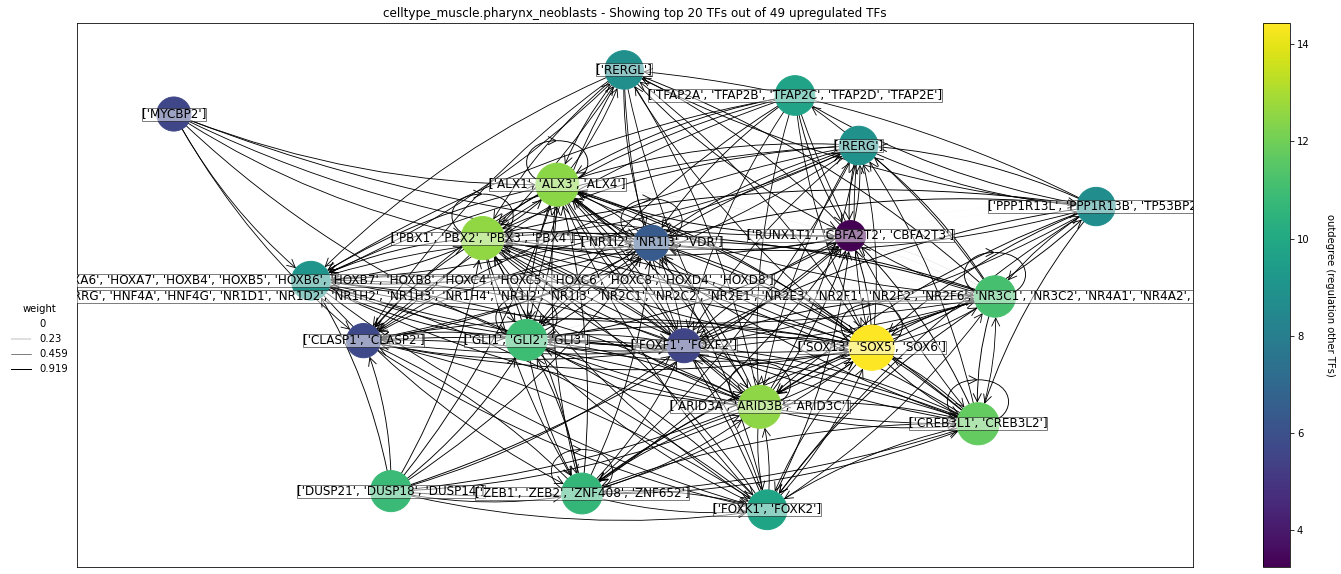

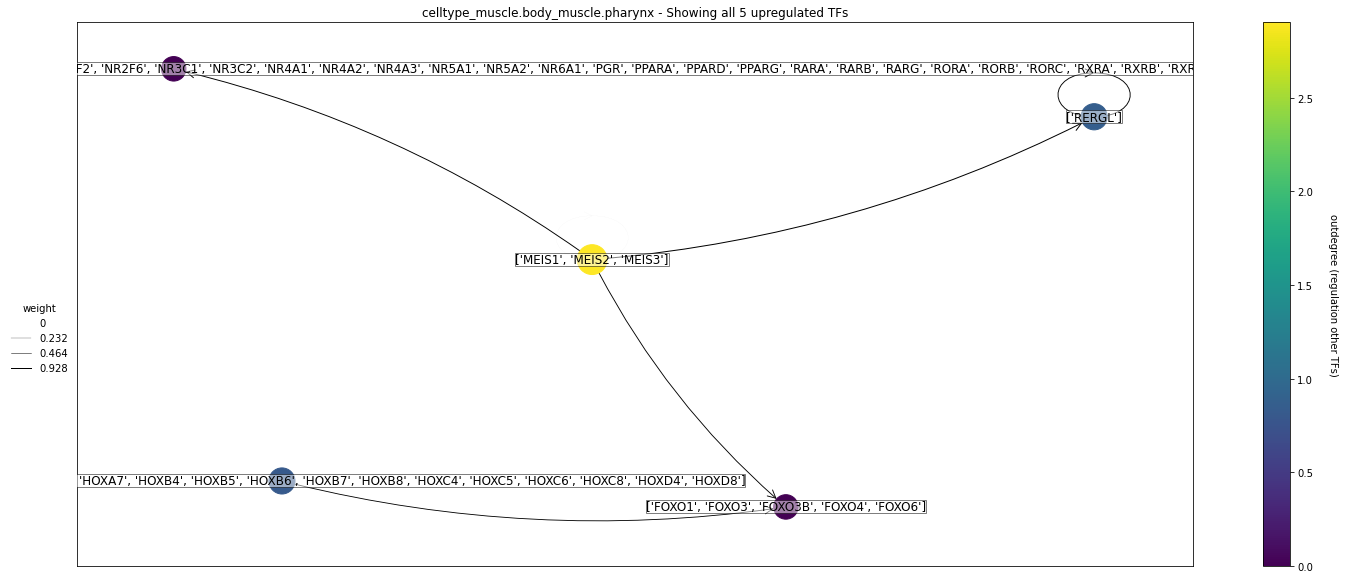

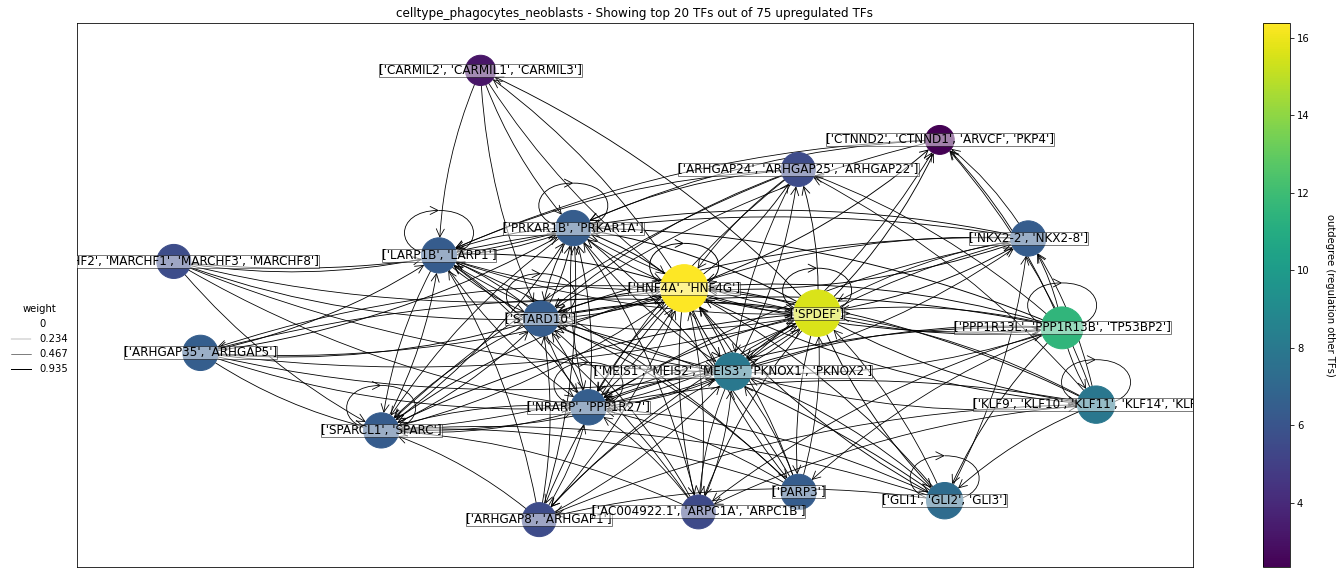

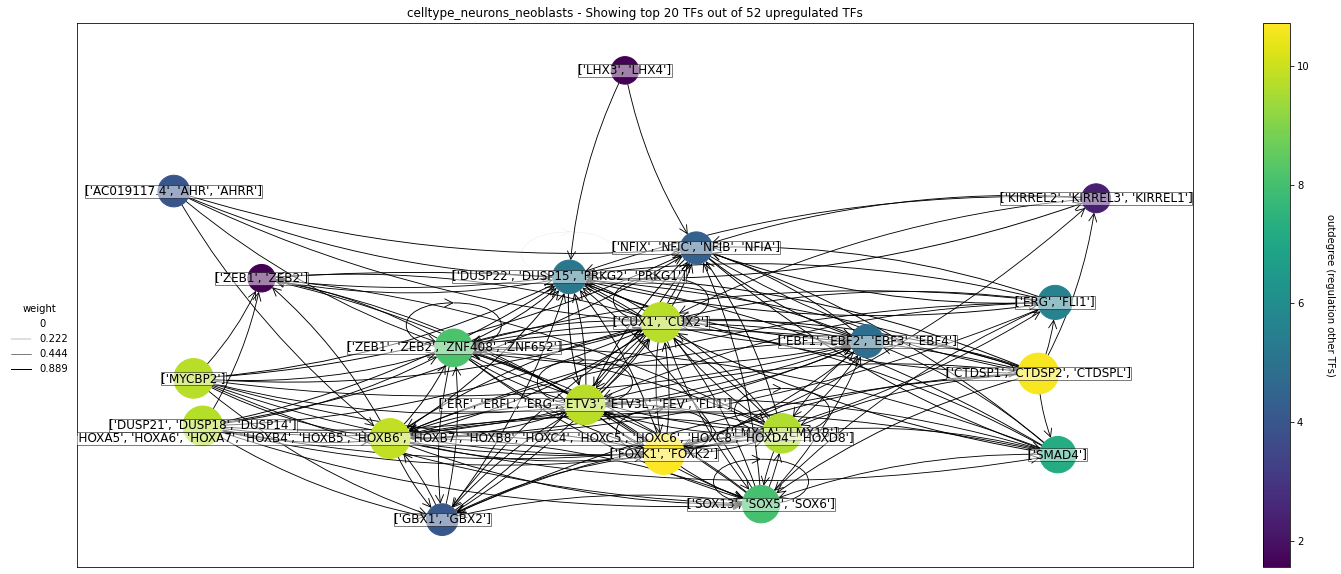

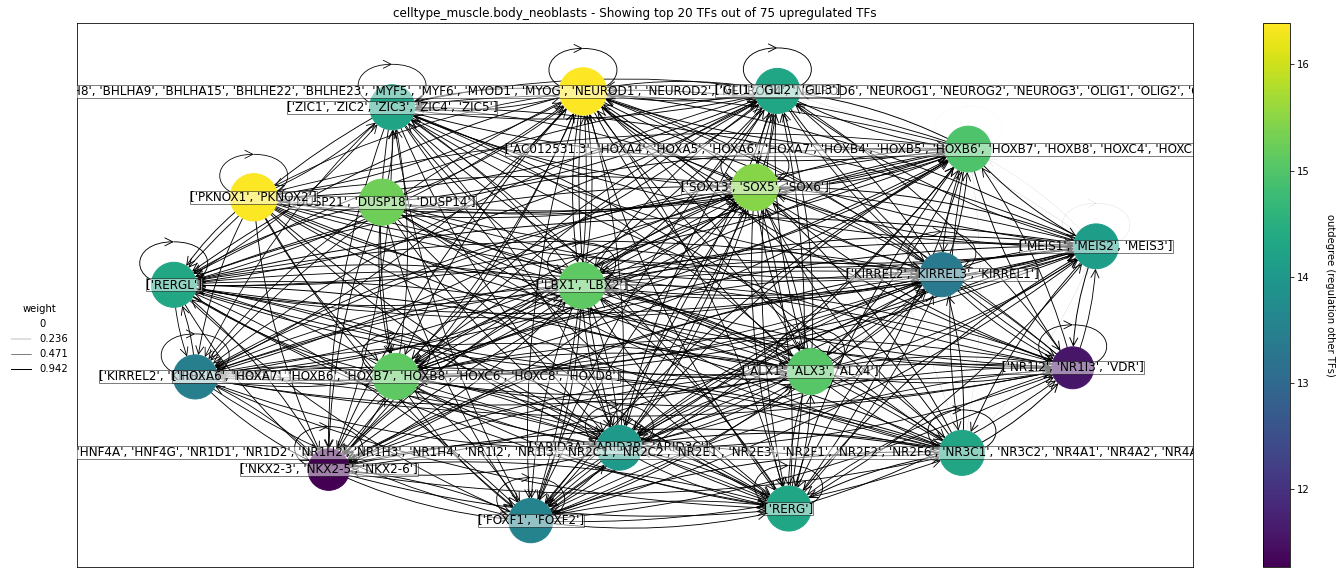

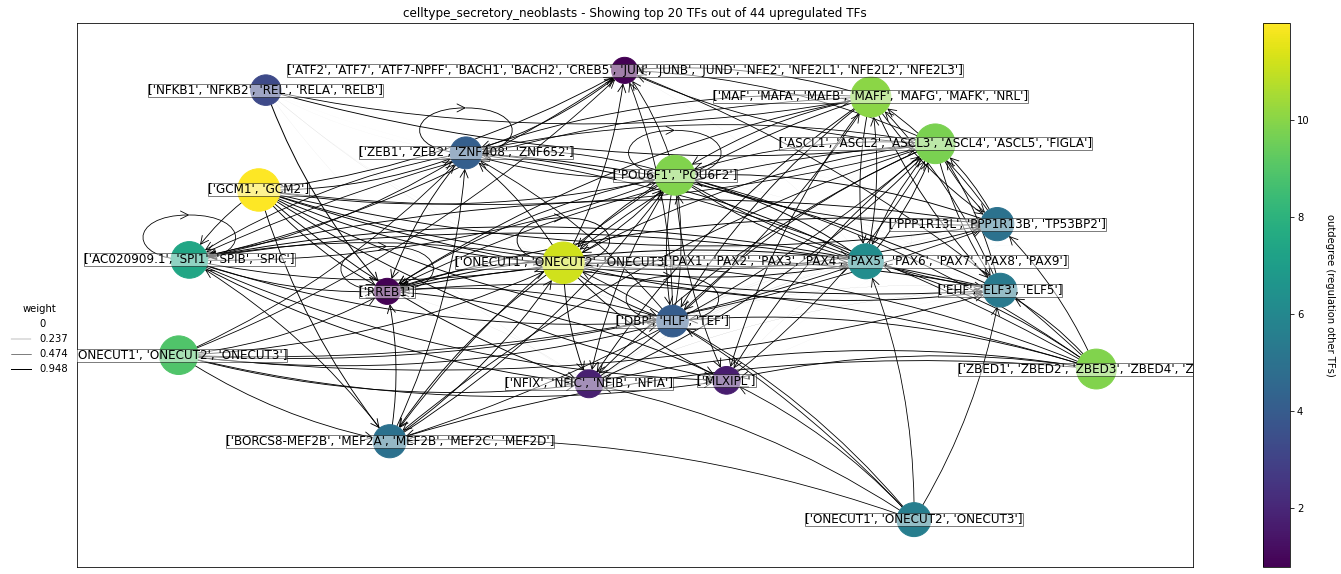

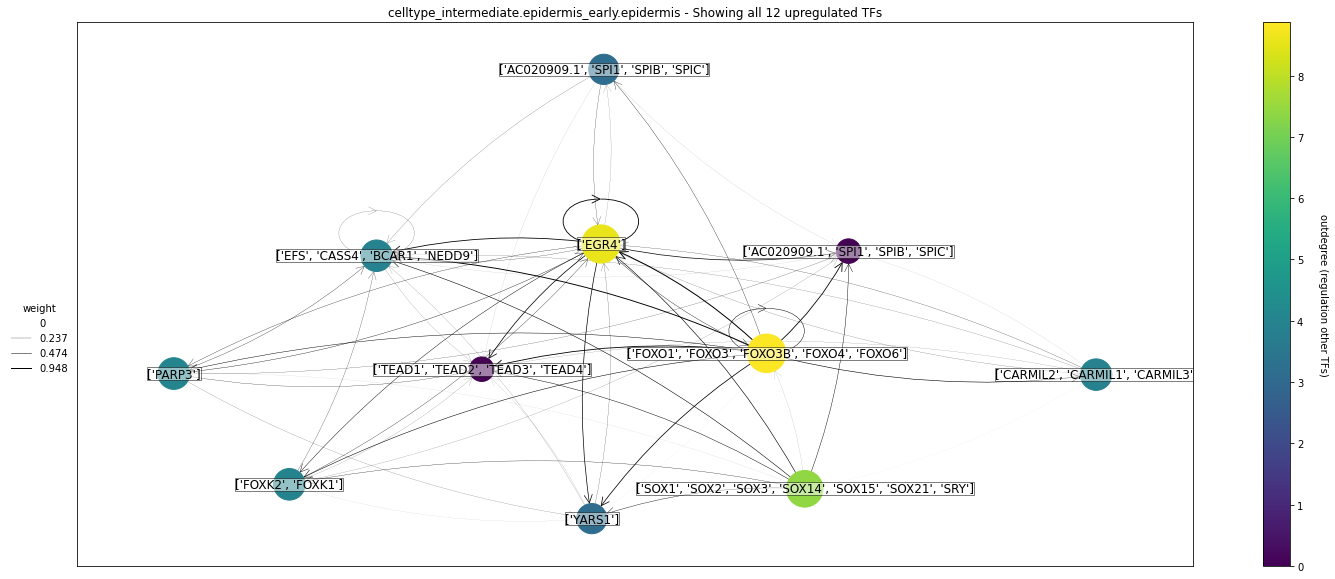

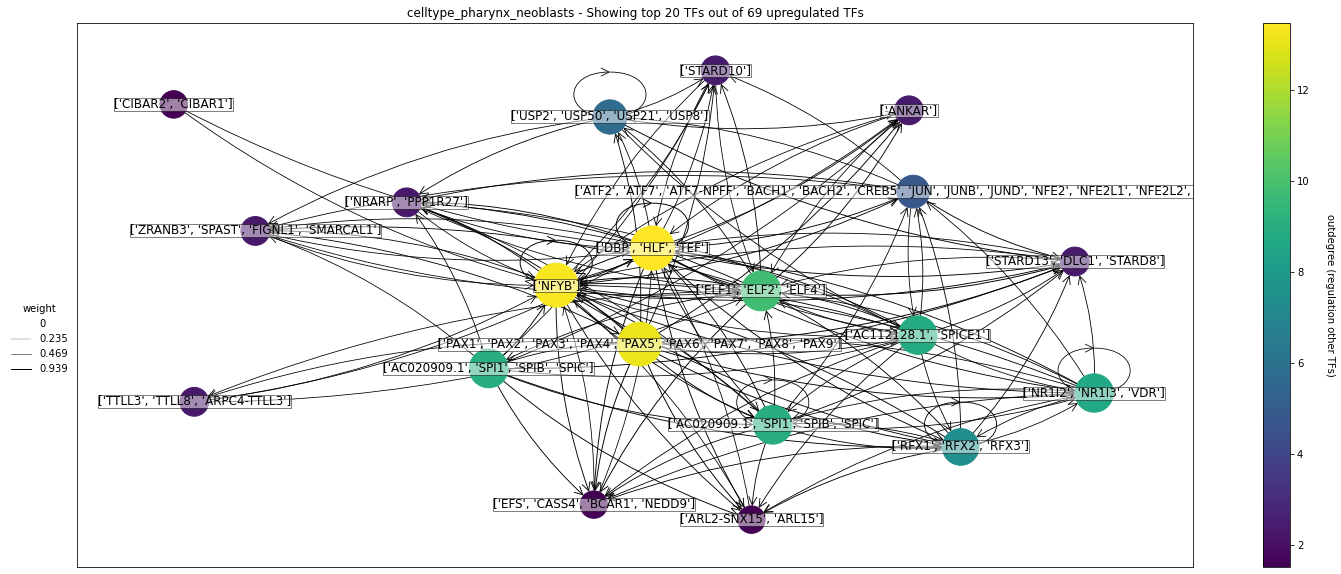

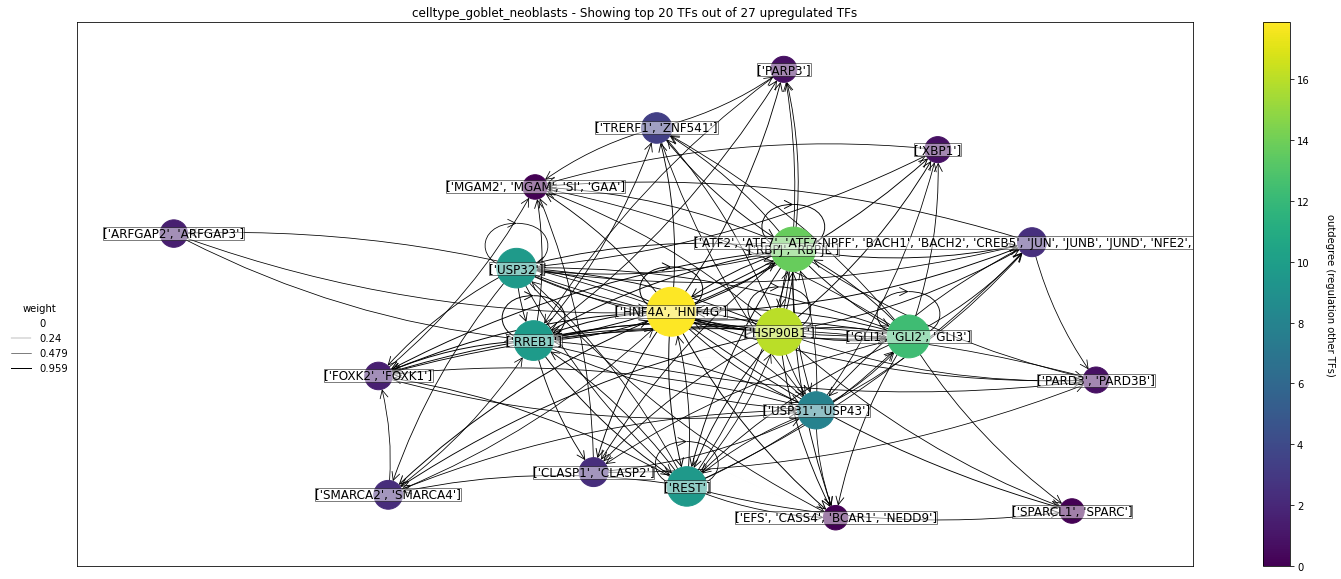

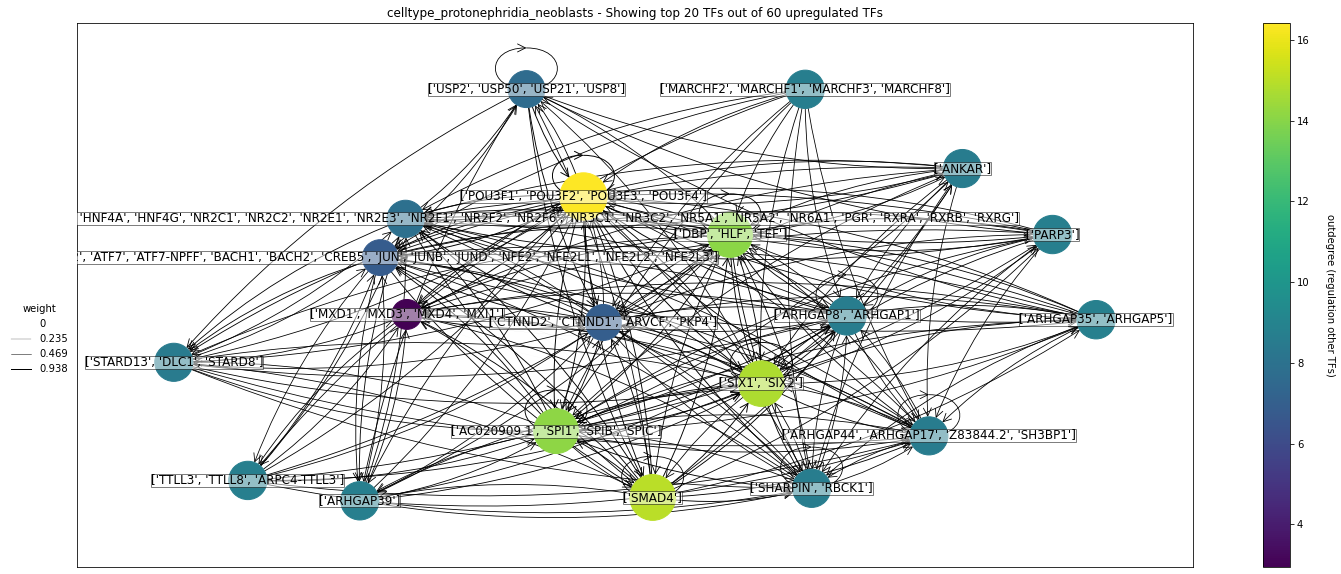

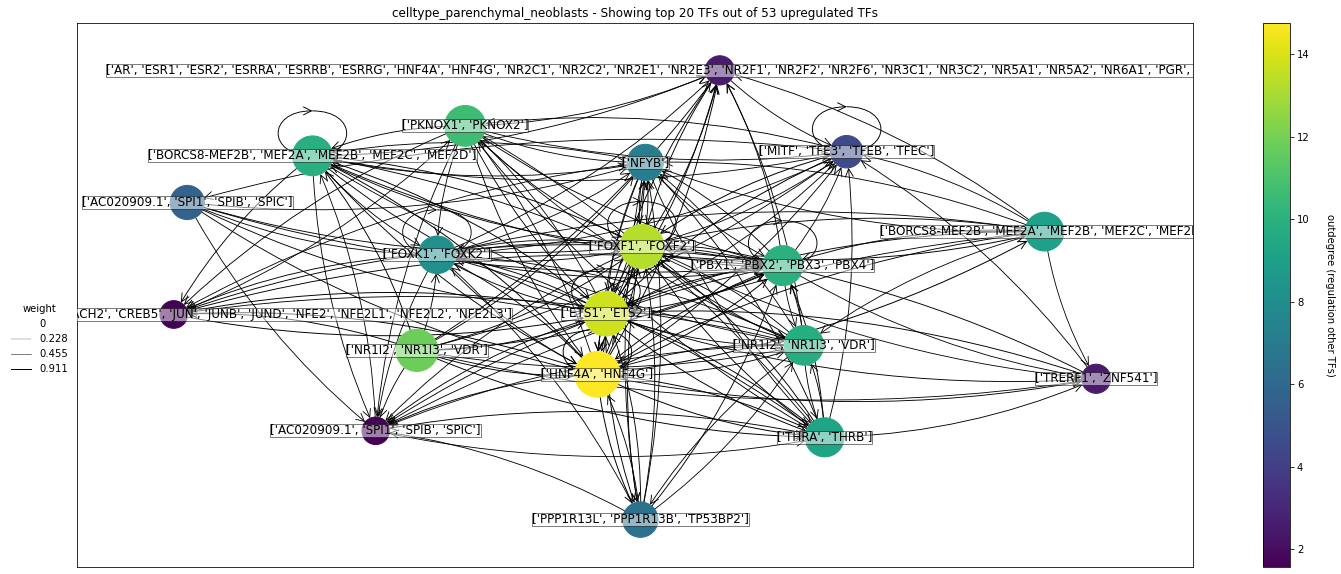

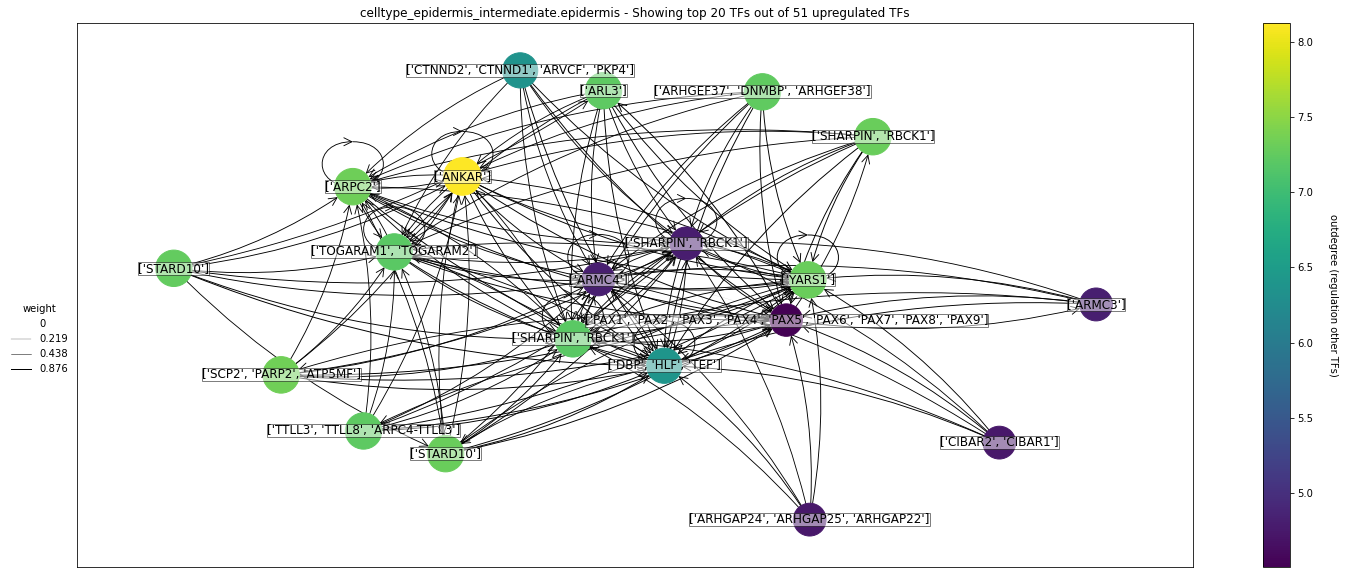

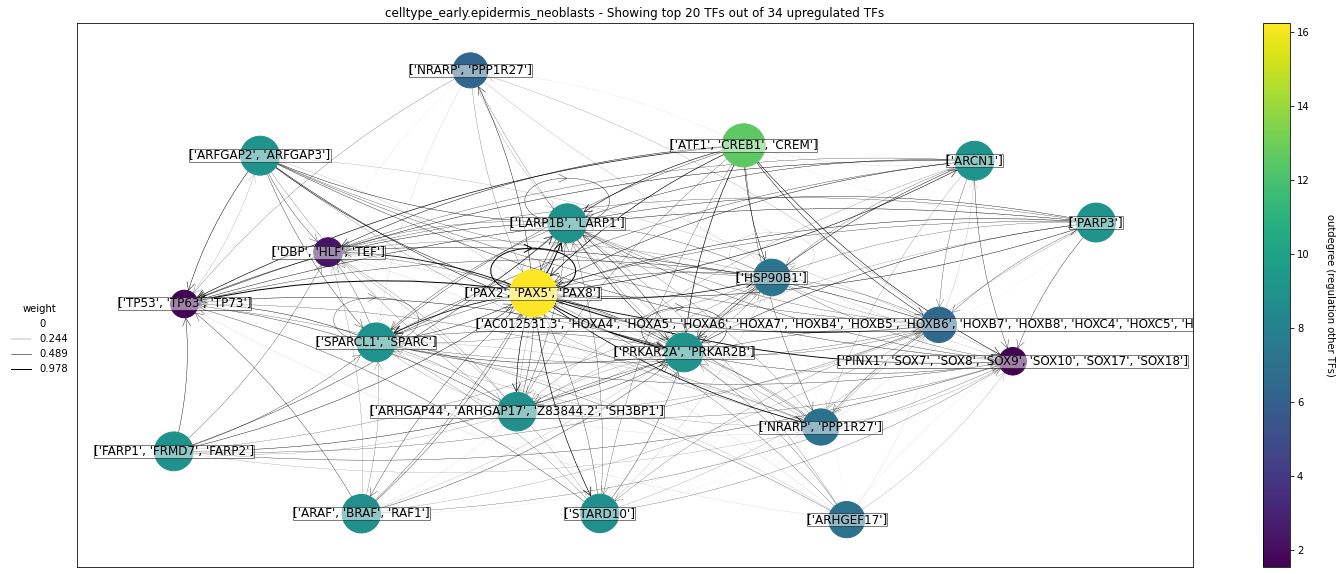

In [7]:
%%capture --no-stdout --no-display

inf_files = [f for f in os.listdir(in_dir) if f[-4:] == ".tsv" and f[-16:] != "_diffnetwork.tsv"]

os.makedirs(out_dir, exist_ok=True)
for inf_file in inf_files:
    out_plot = os.path.join(out_dir, f"{inf_file[:-4]}.{plot_type}")
    inf_file = os.path.join(in_dir, inf_file)
    plot(inf_file, out_plot, n_tfs, edge_info, edge_min, network_algorithm, cmap, save_plot=True, show_plot=True)